<h1><center> Sequential Monte Carlo Method for Filtering

In this notebook we will develop a sequential Monte Carlo method for filtering out the path of some target by collecting measurements from different locations. This could for example be a moving cell phone where different antennas are picking up different signal strengths.

<h2><center> Theory

<h3> Markov chains and hidden Markov models.

A Markov chain has two specific properties. Given the right prerequisites we have,
1.  $\mathbb{P}(X_0 \in A) = \chi(A)$
2. $\mathbb{P}(X_{n+1} \in B \,\vert\, X_0,X_1,...,X_n) = Q_n(X_n; B)$

where $Q_n$ is the Markov kernel at time $n$ and $\chi$ is the initial distribution.

A hidden Markov model (HMM) is a model where an unobservable Markov chain is measured indirectly by some relationship, assumed to be a Markov chain that only depends on the current state of the unobservable process.

<h3> Sequential Monte Carlo problems

TODO: Explain SMC in depth

<h2><center> Problem Formulation

<h3> Motion

We describe the motion as follows. Let $\mathbf{X}_n \in \mathbb{R}^{2\times3}$ denote the state of the target. That is, the motion is taking place in $\mathbb{R}^2$ and for each coordinate, we have 3 quantites, position, velocity and acceleration.
$$\mathbf{X}_n = [X^{1}_n, \dot{X}^{1}_n \ddot{X}^{1}_n, X^{2}_n, \dot{X}^{2}_n \ddot{X}^{2}_n]^\top$$
and the full motion model is 
$$\mathbf{X}_{n+1} = \Phi \mathbf{X}_n + \Psi_z \mathbf{Z}_n + \Psi_w\mathbf{W}_n \quad n=1,2,...,N$$

where $\{\mathbf{W}_n\}_{n=1}^N$ is a bivariate gaussian noise term drawn from $\mathcal{N}(\mathbf{0},\sigma^2 I)$. The middle term $\{\mathbf{Z}_n\}_{n=1}^N$ is by itself a discrete bivariate Markov chain taking values from the set 

$$\mathcal{S} = \left\{ \begin{pmatrix} 0 \\ 0 \end{pmatrix}, \begin{pmatrix} 3.5 \\ 0 \end{pmatrix}, \begin{pmatrix} 0 \\ 3.5\end{pmatrix}, \begin{pmatrix} -3.5 \\ 0 \end{pmatrix}, \begin{pmatrix} 0 \\ -3.5 \end{pmatrix} \right\}.$$

This Markov chain governs the motion commands and evolves according to the transition probability matrix

$$P = \frac{1}{20}\begin{pmatrix} 16 & 1 & 1 & 1 & 1 \\ 1 & 16 & 1 & 1 & 1 \\1 & 1 & 16 & 1 & 1 \\ 1 & 1 & 1 & 16 &1 \\ 1 & 1 & 1 & 1 & 16 \end{pmatrix}$$  

The initial state is $\mathbf{X}_0 \sim \mathcal{N}(0, diag(500,5,5,200,5,5)$ and $\mathbf{Z}_0 = \mathcal{S}(a)$ and $a \sim \mathcal{U}(0,5)$

Furthermore, the matricies in the motion model is given by
$$\Phi = \begin{pmatrix}
1 & \Delta t & \Delta t^2/2 &  &  &  \\
0 & 1 & \Delta t &  & \mathbf{0} &  \\
0 & 0 & \alpha &  &  &  \\ 
 &  &  & 1 & \Delta t & \Delta t^2/2 \\ 
 & \mathbf{0} &  & 0 & 1 &\Delta t \\
 & & & 0 & 0 & \alpha\end{pmatrix}, \quad \Psi_w = \begin{pmatrix} \Delta t^2/2 & 0 \\ \Delta t & 0 \\ 1 & 0 \\ 0& \Delta t^2 /2 \\ 0& \Delta t \\ 0 & 1 \
 \end{pmatrix}, \quad \text{and} \quad \Psi_z = \begin{pmatrix} \Delta t^2/2 & 0 \\ \Delta t & 0 \\ 0 & 0 \\ 0& \Delta t^2 /2 \\ 0& \Delta t \\ 0 & 0 \
 \end{pmatrix}.$$

Is the motion model a Markov chain? As written above, a Markov chain must only depend on the previous state. Since $\mathbf{X}_{n+1}$ depends not only on the previous state, $\mathbf{X}_n$, but also $\mathbf{Z}_n$ the sequence $\{\mathbf{X}_n\}_{n=1}^N$ is not a Markov chain. If we extend the vector into $\mathbf{\tilde{X}} = [\,\mathbf{X}, \mathbf{Z}\,]^\top$ the sequence $\{\mathbf{\tilde{X}}_n\}_{n=1}^N$ we now have a Markov chain.

<h3> Measurements

The targets trajectory is measured by K stations placed at positions $\mathbf{P}^l, \,\, l = 1,2,\dots,K$

$$ Y_n^l = v - 10 \eta \log_{10} \vert\vert (X^1_n,X^2_n)^\top - \mathbf{P}_l\vert\vert + V_n^l, \quad \quad l = 1,2,...,K, $$

where $v, \eta$ are constants and $V_n^l \sim \mathcal{N}(0,\varsigma^2).$ Define $\mathbf{Y}_n = [Y_n^1, Y_n^2,\dots,Y_n^K]$, then the sequence  $\{\mathbf{\tilde{X}}_n, \mathbf{Y}_n\}_{n=1}^N$ forms a <b>hidden markov model</b>

<h2><center> Implementation

In [1]:
import numpy as np
from scipy.stats import norm
from markov_chain import MarkovChain
from measurement import Measurement
import matplotlib.pyplot as plt

The class `MarkovChain` is a generator class which produces the next state as `next(mc)` for the instantiated object `mc`. 
It can be instantiated with any parameters and number of particles. 

The class `Measurement` produces a $\mathbf{Y}$ vector when calling the function `take_measurement()`. Must be instantiated with a `MarkovChain` object.   

The code can be optimized further. For example, the sampling of $\mathbf{Z}_n$ is done in a loop for each particle. In MATLAB, this can be done vectorized using `randsample` but no equivalent function exists in `numpy`. 

In [2]:
num_particles = 10000
dt = 0.5
iter = 500
stations = np.array([[0,0,3464.1,3464.1,-3464.1,-3464.1],[4000,-4000,2000,-2000,-2000,2000]])
num_stations = stations.shape[1]

# Create reference particle to filter out
mc1 = MarkovChain(iter,num_particles=1, dt=dt)
m1 = Measurement(mc1, stations)
print(mc1)


MarkovChain Generator Object 
 
STATE SHAPE: 	 	(6, 1)
MC STATE SHAPE: 	(1,)
Number of particles: 	1

Parameters: 
Noise std: 	0.5
Time step 	0.5
 
Using transition matrix 
[[0.8  0.05 0.05 0.05 0.05]
 [0.05 0.8  0.05 0.05 0.05]
 [0.05 0.05 0.8  0.05 0.05]
 [0.05 0.05 0.05 0.8  0.05]
 [0.05 0.05 0.05 0.05 0.8 ]]


In [3]:

# Create many particles
mc2 = MarkovChain(iter,num_particles=num_particles, dt=dt)
m2 = Measurement(mc2, stations)

X_real = np.empty(shape=(iter,2))
Y_real = np.empty(shape=(iter,6))
tau = np.empty(shape=(iter,2))

for i in range(iter):
    
    # Create a 'real' measurement
    state, measurements = m1.take_measurement()
    X_real[i,:] = np.array([state[0],state[3]]).ravel()
    Y_real[i,:] = np.array(measurements.ravel())
    
    # Create many simulated particles and use SISR to filter out the path
    state, measurements = m2.take_measurement()
    w = np.prod(norm.pdf(Y_real[i], loc = measurements, scale=1.5) , axis=1)
    idx = np.random.choice(np.arange(0,num_particles), num_particles,  p = w/sum(w))
    state = state[:,idx]
    mc2.state = state
    mc2.mc_state = mc2.mc_state[idx]

    omega= sum(w)
    tau[i,:] = np.array([ np.multiply(state[0,:],w).sum()/omega, np.multiply(state[3,:],w).sum()/omega])
    
    if i % 50 == 0:
        print('Iteration ', i+1, 'of ', iter, ' completed.')

Iteration  1 of  500  completed.
Iteration  51 of  500  completed.
Iteration  101 of  500  completed.
Iteration  151 of  500  completed.
Iteration  201 of  500  completed.
Iteration  251 of  500  completed.
Iteration  301 of  500  completed.
Iteration  351 of  500  completed.
Iteration  401 of  500  completed.
Iteration  451 of  500  completed.


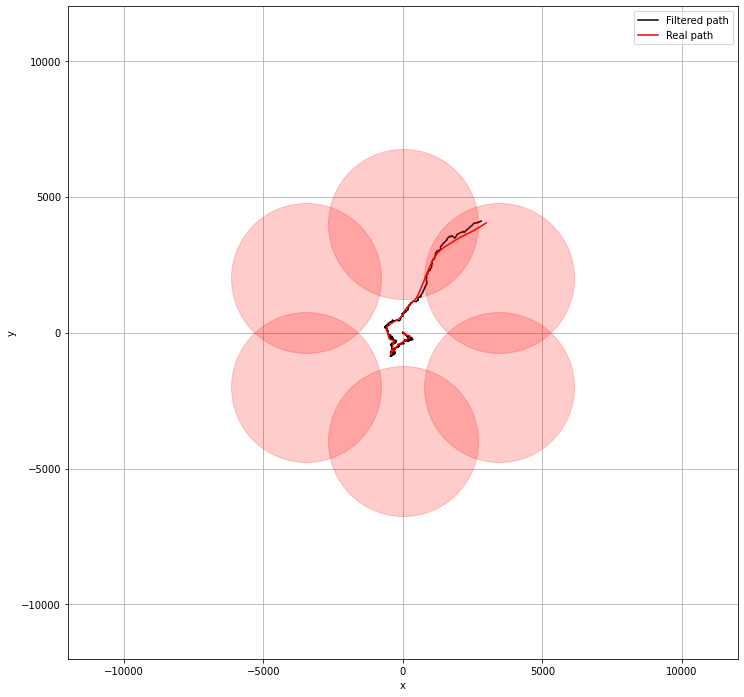

In [4]:
plt.rcParams["figure.figsize"] = (12,12)
plt.plot(tau[:,0], tau[:,1],'k', label='Filtered path')
plt.plot(X_real[:,0], X_real[:,1]  ,'r', label='Real path')
plt.plot(stations[0,:], stations[1,:],'ro', markersize=150, alpha=0.2)
plt.axis(np.array([min(stations[1,:]),max(stations[1,:]),min(stations[1,:]),max(stations[1,:])])*3)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

<h2><center> Testing a different path

It seems reasonable that we can generate a path using the markov motion model, take measurements and then filter it out well. But what if the path is not generated by that motion model? Will the results be any good? Let us try to change the transition density and the noise parameter $\sigma$

In [10]:
# Create reference particle to filter out
mc3 = MarkovChain(iter,num_particles=1, dt=dt, sigma=1)
mc3.transition_matrix = np.array([[12,2,1,3,2],[1,12,3,2,2],[2,3,12,2,1],[3,1,2,12,2],[1,2,3,2,12]])/20
m3 = Measurement(mc3, stations)
print(mc3)


MarkovChain Generator Object 
 
STATE SHAPE: 	 	(6, 1)
MC STATE SHAPE: 	(1,)
Number of particles: 	1

Parameters: 
Noise std: 	1
Time step 	0.5
 
Using transition matrix 
[[0.6  0.1  0.05 0.15 0.1 ]
 [0.05 0.6  0.15 0.1  0.1 ]
 [0.1  0.15 0.6  0.1  0.05]
 [0.15 0.05 0.1  0.6  0.1 ]
 [0.05 0.1  0.15 0.1  0.6 ]]


In [11]:


# Create many particles
mc4 = MarkovChain(iter,num_particles=num_particles, dt=dt)
m4 = Measurement(mc4, stations)

X_real2 = np.empty(shape=(iter,2))
Y_real2 = np.empty(shape=(iter,6))
tau2 = np.empty(shape=(iter,2))

for i in range(iter):
    
    # Create a 'real' measurement
    state, measurements = m3.take_measurement()
    X_real2[i,:] = np.array([state[0],state[3]]).ravel()
    Y_real2[i,:] = np.array(measurements.ravel())
    
    # Create many simulated particles and use SISR to filter out the path
    state, measurements = m4.take_measurement()
    w = np.prod(norm.pdf(Y_real2[i], loc = measurements, scale=1.5) , axis=1)
    idx = np.random.choice(np.arange(0,num_particles), num_particles,  p = w/sum(w))
    state = state[:,idx]
    mc4.state = state
    mc4.mc_state = mc4.mc_state[idx]

    omega= sum(w)
    tau2[i,:] = np.array([ np.multiply(state[0,:],w).sum()/omega, np.multiply(state[3,:],w).sum()/omega])
    
    if i % 50 == 0:
        print('Iteration ', i+1, 'of ', iter, ' completed.')

Iteration  1 of  500  completed.
Iteration  51 of  500  completed.
Iteration  101 of  500  completed.
Iteration  151 of  500  completed.
Iteration  201 of  500  completed.
Iteration  251 of  500  completed.
Iteration  301 of  500  completed.
Iteration  351 of  500  completed.
Iteration  401 of  500  completed.
Iteration  451 of  500  completed.


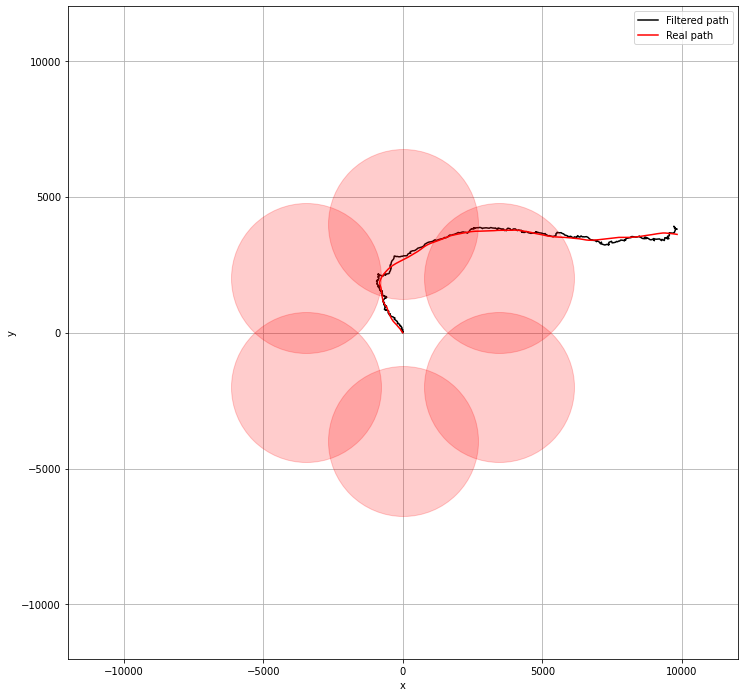

In [12]:
plt.rcParams["figure.figsize"] = (12,12)
plt.plot(tau2[:,0], tau2[:,1],'k', label='Filtered path')
plt.plot(X_real2[:,0], X_real2[:,1]  ,'r', label='Real path')
plt.plot(stations[0,:], stations[1,:],'ro', markersize=150, alpha=0.2)
plt.axis(np.array([min(stations[1,:]),max(stations[1,:]),min(stations[1,:]),max(stations[1,:])])*3)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()